<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/MSFT_learning_02_computervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **下載與檢視 資料集**
1. **MNIST手寫數字辨識**
2. dataset, dataloader
3. 檢視相關資訊

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
# datasets
train_dataset = torchvision.datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_dataset = torchvision.datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 94857177.64it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 117265918.51it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25300498.98it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 27892428.65it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# dataloader
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = 64,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = 64,
                             shuffle = True)

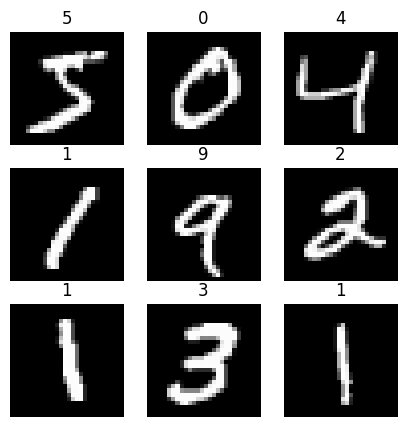

In [4]:
# 隨機檢視圖片
train_dataset[0]

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3

for i in range(9):
    figure.add_subplot(cols, rows, i+1)
    plt.imshow(train_dataset[i][0].squeeze(), cmap="gray")
    plt.title(train_dataset[i][1])
    plt.axis("off")

In [5]:
# 檢視資料資訊
print(f"訓練資料數量: {len(train_dataset)}")
print(f"測試資料數量: {len(test_dataset)}\n")
print(f"圖片資料: {train_dataset[0][0].size()}")

訓練資料數量: 60000
測試資料數量: 10000

圖片資料: torch.Size([1, 28, 28])


# **Model_1 & functions**
1. Model_1 -> one Linear layer
2. Func : train, test, training loop ...

## 1.1 pip & import

In [6]:
!pip install torchinfo

In [7]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary

## 1.2 Model structure & build model

In [8]:
# Model structure & build model
device = "cuda" if torch.cuda.is_available() else "cpu"

class simpleNET(nn.Module):
    def __init__(self):
        super(simpleNET, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        probs = self.layer_1(x)
        return probs

model_1 = simpleNET().to(device)
summary(model_1)

Layer (type:depth-idx)                   Param #
simpleNET                                --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       7,850
│    └─LogSoftmax: 2-3                   --
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0

## 1.3 Train function

In [9]:
# Train function
def train(model, dataloader, loss_fn, optimizer):
    model.train()

    total_loss, acc, count = 0, 0, 0

    for features, labels in dataloader:
        probs = model(features)
        loss = loss_fn(probs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss
        _, predicted = torch.max(probs, 1) # 找出probs 第一維度的最大值 -> 第一變數, 最大值是哪一個(較不重要, 所以使用_) / 第二變數, 最大值所在index (label)
        acc = acc + (predicted == labels).sum() # 僅計算, 預測label = True label
        count = count + len(labels)

        return total_loss.item()/count, acc.item()/count

In [10]:
#
print("Only for further understanding")
print(torch.max(model_1(next(iter(train_dataloader))[0]),1))

Only for further understanding
torch.return_types.max(
values=tensor([-2.0868, -2.1050, -2.0906, -1.9445, -1.9550, -2.0046, -2.0859, -2.1441,
        -1.9861, -1.8945, -2.0513, -2.1539, -2.1564, -2.0427, -2.0022, -2.1226,
        -2.2124, -2.1086, -2.0343, -2.0655, -2.1612, -2.0244, -2.0501, -1.9859,
        -2.1355, -2.0749, -2.1237, -1.9559, -2.0972, -2.1284, -2.1132, -1.9250,
        -2.1351, -2.0462, -2.1133, -2.0723, -1.9086, -2.1594, -1.9316, -2.1850,
        -2.1498, -2.0473, -2.1145, -2.0851, -2.1483, -2.0869, -2.0818, -2.1430,
        -2.1617, -2.1097, -1.8603, -2.0782, -1.9461, -2.1015, -2.0037, -1.9656,
        -1.9349, -1.9752, -2.1656, -1.9355, -2.0293, -2.1802, -2.0671, -2.0396],
       grad_fn=<MaxBackward0>),
indices=tensor([8, 3, 2, 5, 5, 5, 4, 5, 4, 9, 9, 0, 2, 5, 5, 1, 9, 5, 2, 6, 7, 1, 9, 5,
        5, 5, 5, 9, 1, 6, 4, 6, 6, 9, 5, 5, 5, 2, 5, 2, 5, 5, 7, 9, 6, 9, 0, 7,
        4, 1, 5, 0, 5, 0, 5, 5, 5, 5, 6, 3, 5, 1, 1, 9]))


In [11]:
# 測試 train function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                            lr=0.01)

loss, acc = train(model = model_1,
                  dataloader = train_dataloader,
                  loss_fn = loss_fn,
                  optimizer = optimizer)

print(f"Train -> Loss: {loss} | Accuracy: {acc}")

Train -> Loss: 0.03582962229847908 | Accuracy: 0.09375


## 1.4 Test function

In [12]:
# Test function
def test(model, dataloader, loss_fn):
    model.eval()

    total_loss, acc, count = 0, 0, 0
    with torch.inference_mode():
        for features, labels in dataloader:
            probs = model(features)
            loss = loss_fn(probs, labels)
            # accumulate total_loss
            total_loss = total_loss + loss
            _, predicted = torch.max(probs, 1)
            # accumulate accuracy predict
            acc = acc + (predicted == labels).sum() # 僅計算, 預測label = True label
            count = count + len(labels)
    return total_loss.item()/count, acc.item()/count

In [13]:
# 測試 test function
loss_fn = nn.CrossEntropyLoss()

loss, acc = test(model = model_1,
                 dataloader = test_dataloader,
                 loss_fn = loss_fn)

print(f"Test -> Loss: {loss} | Accuracy: {acc}")

Test -> Loss: 0.031007061767578125 | Accuracy: 0.2988


## 1.5 Training loop function and training loop
1. function
2. training loop
3. visualize

In [14]:
# Training loop function

def training_loop(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs):
    # 空字典, 用於儲存結果
    result_dict = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}

    for epoch in range(epochs):
        # train function
        train_loss, train_acc = train(model, train_dataloader, loss_fn, optimizer)

        # test function
        test_loss, test_acc = test(model, test_dataloader, loss_fn)

        # print process
        print(f"Epoch: {epoch}:")
        print(f"Train loss: {train_loss:.2f} | Train accuracy: {train_acc*100:.2f}%")
        print(f"Test loss: {test_loss:.2f} | Test accuracy: {test_acc*100:.2f}%")

        # 將結果存入字典
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)

    return result_dict

In [15]:
# Training loop
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.01)

result = training_loop(model_1, train_dataloader, test_dataloader,
                       loss_fn = loss_fn,
                       optimizer = optimizer,
                       epochs=25)

Epoch: 0:
Train loss: 0.03 | Train accuracy: 34.38%
Test loss: 0.03 | Test accuracy: 55.57%
Epoch: 1:
Train loss: 0.03 | Train accuracy: 48.44%
Test loss: 0.02 | Test accuracy: 55.25%
Epoch: 2:
Train loss: 0.03 | Train accuracy: 43.75%
Test loss: 0.02 | Test accuracy: 66.25%
Epoch: 3:
Train loss: 0.02 | Train accuracy: 60.94%
Test loss: 0.02 | Test accuracy: 70.38%
Epoch: 4:
Train loss: 0.02 | Train accuracy: 70.31%
Test loss: 0.02 | Test accuracy: 77.10%
Epoch: 5:
Train loss: 0.02 | Train accuracy: 76.56%
Test loss: 0.01 | Test accuracy: 79.26%
Epoch: 6:
Train loss: 0.02 | Train accuracy: 68.75%
Test loss: 0.01 | Test accuracy: 80.46%
Epoch: 7:
Train loss: 0.01 | Train accuracy: 84.38%
Test loss: 0.01 | Test accuracy: 80.76%
Epoch: 8:
Train loss: 0.01 | Train accuracy: 82.81%
Test loss: 0.01 | Test accuracy: 81.87%
Epoch: 9:
Train loss: 0.01 | Train accuracy: 79.69%
Test loss: 0.01 | Test accuracy: 82.28%
Epoch: 10:
Train loss: 0.01 | Train accuracy: 81.25%
Test loss: 0.01 | Test accu

## 1.6 Visual model_1

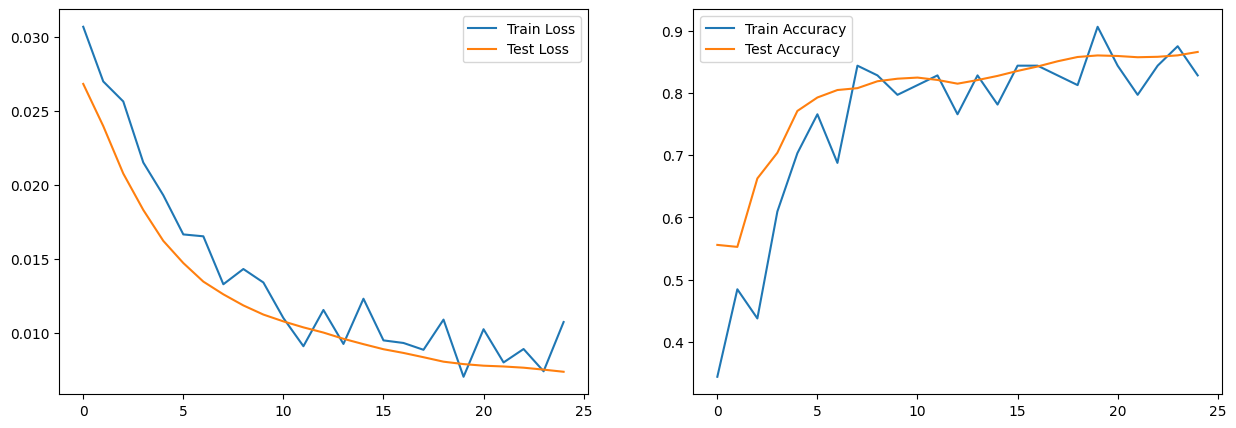

In [16]:
# Visualize
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(result["train_loss"], label="Train Loss")
plt.plot(result["test_loss"], label="Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result["train_acc"], label="Train Accuracy")
plt.plot(result["test_acc"], label="Test Accuracy")
plt.legend()

# **Model_2**
1. Model_2 -> multi Linear layer & **activation**
2. 兩模型結果圖像化

## 2.1 Model structure & build model

In [17]:
# Model structure & build model
device = "cuda" if torch.cuda.is_available() else "cpu"

class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        probs = self.layer_1(x)
        return probs

model_2 = CNN_2().to(device)
summary(model_2, input_size = (1, 28, 28), device = device)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_2                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 100]                  78,500
│    └─ReLU: 2-3                         [1, 100]                  --
│    └─Linear: 2-4                       [1, 10]                   1,010
│    └─LogSoftmax: 2-5                   [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

## 2.2 Training loop

In [18]:
# Training loop
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(),
                             lr = 0.01)

result_2 = training_loop(model_2, train_dataloader, test_dataloader,
                         loss_fn = loss_fn,
                         optimizer = optimizer,
                         epochs=25)

Epoch: 0:
Train loss: 0.04 | Train accuracy: 7.81%
Test loss: 0.03 | Test accuracy: 31.08%
Epoch: 1:
Train loss: 0.03 | Train accuracy: 35.94%
Test loss: 0.03 | Test accuracy: 46.18%
Epoch: 2:
Train loss: 0.03 | Train accuracy: 54.69%
Test loss: 0.02 | Test accuracy: 57.27%
Epoch: 3:
Train loss: 0.02 | Train accuracy: 64.06%
Test loss: 0.02 | Test accuracy: 65.55%
Epoch: 4:
Train loss: 0.02 | Train accuracy: 65.62%
Test loss: 0.02 | Test accuracy: 61.40%
Epoch: 5:
Train loss: 0.02 | Train accuracy: 59.38%
Test loss: 0.02 | Test accuracy: 63.96%
Epoch: 6:
Train loss: 0.02 | Train accuracy: 65.62%
Test loss: 0.01 | Test accuracy: 74.02%
Epoch: 7:
Train loss: 0.01 | Train accuracy: 70.31%
Test loss: 0.01 | Test accuracy: 78.97%
Epoch: 8:
Train loss: 0.01 | Train accuracy: 67.19%
Test loss: 0.01 | Test accuracy: 74.91%
Epoch: 9:
Train loss: 0.01 | Train accuracy: 82.81%
Test loss: 0.01 | Test accuracy: 74.36%
Epoch: 10:
Train loss: 0.01 | Train accuracy: 70.31%
Test loss: 0.01 | Test accur

## 2.3 Visualize 2 models

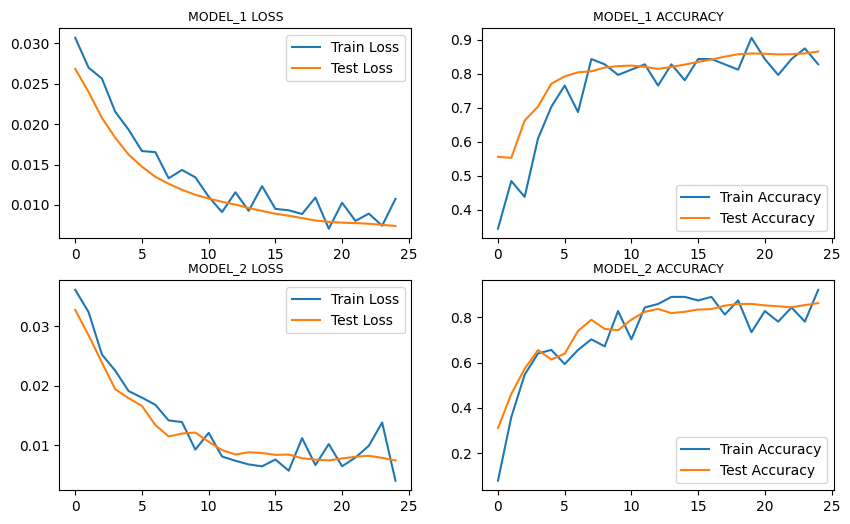

In [19]:
# Visualize
plt.figure(figsize=(10, 6))


plt.subplot(2, 2, 1)
plt.plot(result["train_loss"], label="Train Loss")
plt.plot(result["test_loss"], label="Test Loss")
plt.title("MODEL_1 LOSS", fontsize=9)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(result["train_acc"], label="Train Accuracy")
plt.plot(result["test_acc"], label="Test Accuracy")
plt.title("MODEL_1 ACCURACY", fontsize=9)
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(result_2["train_loss"], label="Train Loss")
plt.plot(result_2["test_loss"], label="Test Loss")
plt.title("MODEL_2 LOSS", fontsize=9)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(result_2["train_acc"], label="Train Accuracy")
plt.plot(result_2["test_acc"], label="Test Accuracy")
plt.title("MODEL_2 ACCURACY", fontsize=9)
plt.legend()

# **Model_3**
1. Model_3 -> CNN
2. Conv2d -> Activation -> Flatten -> Output
3. 3模型視覺比較

## 3.1 Import

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchinfo import summary

## 3.2 Model structure & build model

In [21]:
# Model structure and build model
device = "cuda" if torch.cuda.is_available() else "cpu"

class CNN_3(nn.Module):
    def __init__(self):
        super(CNN_3, self).__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(6760, 10), # 先設置(1, 10) ->
            # RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x6760 and 1x10)
            # -> nn.Linear(6760, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        probs = self.block_1(x)
        return probs

model_3 = CNN_3().to(device)
summary(model_3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_3                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 10, 26, 26]           100
│    └─ReLU: 2-2                         [1, 10, 26, 26]           --
│    └─Flatten: 2-3                      [1, 6760]                 --
│    └─Linear: 2-4                       [1, 10]                   67,610
│    └─LogSoftmax: 2-5                   [1, 10]                   --
Total params: 67,710
Trainable params: 67,710
Non-trainable params: 0
Total mult-adds (M): 0.14
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.27
Estimated Total Size (MB): 0.33

## 3.3 Training Loop

In [22]:
# training loop
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_3.parameters(),
                             lr = 0.01)

result_3 = training_loop(model_3, train_dataloader, test_dataloader,
                         loss_fn = loss_fn,
                         optimizer = optimizer,
                         epochs = 25)

Epoch: 0:
Train loss: 0.04 | Train accuracy: 10.94%
Test loss: 0.09 | Test accuracy: 12.20%
Epoch: 1:
Train loss: 0.09 | Train accuracy: 15.62%
Test loss: 0.09 | Test accuracy: 19.69%
Epoch: 2:
Train loss: 0.10 | Train accuracy: 17.19%
Test loss: 0.04 | Test accuracy: 33.11%
Epoch: 3:
Train loss: 0.05 | Train accuracy: 35.94%
Test loss: 0.04 | Test accuracy: 19.27%
Epoch: 4:
Train loss: 0.05 | Train accuracy: 18.75%
Test loss: 0.04 | Test accuracy: 37.21%
Epoch: 5:
Train loss: 0.03 | Train accuracy: 40.62%
Test loss: 0.04 | Test accuracy: 28.96%
Epoch: 6:
Train loss: 0.04 | Train accuracy: 23.44%
Test loss: 0.03 | Test accuracy: 38.44%
Epoch: 7:
Train loss: 0.04 | Train accuracy: 35.94%
Test loss: 0.02 | Test accuracy: 58.18%
Epoch: 8:
Train loss: 0.02 | Train accuracy: 59.38%
Test loss: 0.02 | Test accuracy: 69.11%
Epoch: 9:
Train loss: 0.03 | Train accuracy: 64.06%
Test loss: 0.02 | Test accuracy: 64.50%
Epoch: 10:
Train loss: 0.02 | Train accuracy: 56.25%
Test loss: 0.02 | Test accu

## 3.4 Visualize 3 models
-> conv2d best accuracy is better

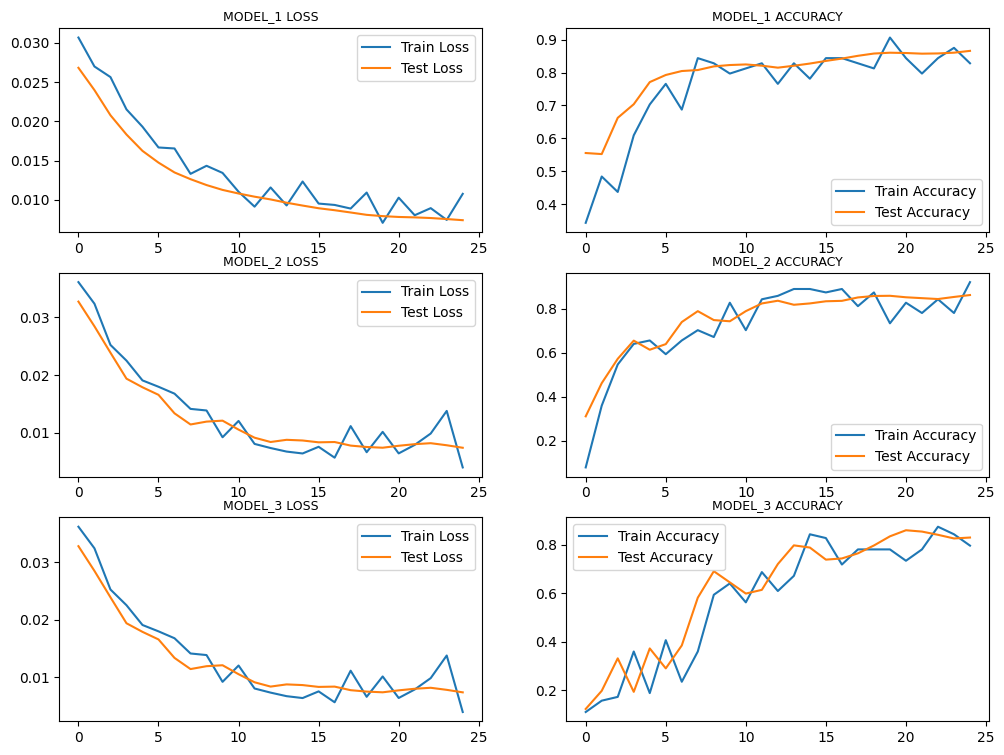

In [23]:
# Visualize
plt.figure(figsize=(12, 9))


plt.subplot(3, 2, 1)
plt.plot(result["train_loss"], label="Train Loss")
plt.plot(result["test_loss"], label="Test Loss")
plt.title("MODEL_1 LOSS", fontsize=9)
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(result["train_acc"], label="Train Accuracy")
plt.plot(result["test_acc"], label="Test Accuracy")
plt.title("MODEL_1 ACCURACY", fontsize=9)
plt.legend()


plt.subplot(3, 2, 3)
plt.plot(result_2["train_loss"], label="Train Loss")
plt.plot(result_2["test_loss"], label="Test Loss")
plt.title("MODEL_2 LOSS", fontsize=9)
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(result_2["train_acc"], label="Train Accuracy")
plt.plot(result_2["test_acc"], label="Test Accuracy")
plt.title("MODEL_2 ACCURACY", fontsize=9)
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(result_2["train_loss"], label="Train Loss")
plt.plot(result_2["test_loss"], label="Test Loss")
plt.title("MODEL_3 LOSS", fontsize=9)
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(result_3["train_acc"], label="Train Accuracy")
plt.plot(result_3["test_acc"], label="Test Accuracy")
plt.title("MODEL_3 ACCURACY", fontsize=9)
plt.legend()

# **Model_4**
1. CIFAR10
2. dataset, dataloader
3. Model_4 -> CNN multilayers


## 4.1 Import

In [24]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

## 4.2 CIFAR10

In [25]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [26]:
# Datasets
train_dataset = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = transform)

test_dataset = datasets.CIFAR10(
    root = "data",
    train = False,
    download = True,
    transform = transform)

100%|██████████| 170498071/170498071 [00:01<00:00, 97491329.67it/s] 


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [35]:
# DataLoader
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 150,
    shuffle = True)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = 150,
    shuffle = False)

In [28]:
# label
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

torch.Size([150, 3, 32, 32])


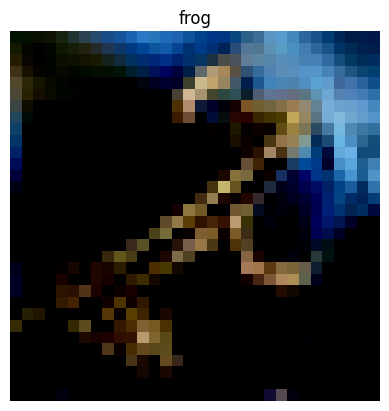

In [36]:
# 檢視資料集中圖像
iter_data = iter(train_dataloader)
image, label_index = next(iter_data)

print(image.size())
image = np.array(image[0].permute(1, 2, 0))
plt.imshow(image)

plt.title(classes[label_index[0]])
plt.gca().set_axis_off()

## 4.3 Model structure & build model


In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
class CNN_4(nn.Module):
    def __init__(self):
        super(CNN_4, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.pool = nn.MaxPool2d(2)
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(in_features=64, out_features=16)
        self.linear2 = nn.Linear(in_features=16, out_features=10)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        # print(x.size())
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # print(x.size())

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        # print(x.size())

        x = self.flat(x)
        # print(x.size())
        x = nn.functional.relu(self.linear1(x))
        # print(x.size())
        x = self.linear2(x)
        # print(x.size())
        x = self.logsoftmax(x)
        # print(x.size())
        return x


model_4 = CNN_4().to(device)
summary(model_4, input_size=(1, 3, 32, 32))
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1920 and 120x64)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_4                                    [1, 10]                   73,856
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─MaxPool2d: 1-2                         [1, 32, 16, 16]           --
├─Conv2d: 1-3                            [1, 64, 16, 16]           18,496
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─AdaptiveAvgPool2d: 1-5                 [1, 64, 1, 1]             --
├─Flatten: 1-6                           [1, 64]                   --
├─Linear: 1-7                            [1, 16]                   1,040
├─Linear: 1-8                            [1, 10]                   170
├─LogSoftmax: 1-9                        [1, 10]                   --
Total params: 94,458
Trainable params: 94,458
Non-trainable params: 0
Total mult-adds (M): 5.65
Input size (MB): 0.01
Forward/backward pass size (MB): 0.39
Params size (MB): 0.08
Estimated Total Size (MB): 0.49

## 4.4 Training loop

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_4.parameters(),
                             lr = 0.05)

result_4 = training_loop(model_4, train_dataloader, test_dataloader,
                         loss_fn = loss_fn,
                         optimizer = optimizer,
                         epochs = 25)

Epoch: 0:
Train loss: 0.01 | Train accuracy: 19.33%
Test loss: 0.03 | Test accuracy: 9.59%
Epoch: 1:
Train loss: 0.03 | Train accuracy: 14.00%
Test loss: 0.02 | Test accuracy: 11.35%
Epoch: 2:
Train loss: 0.02 | Train accuracy: 8.00%
Test loss: 0.02 | Test accuracy: 14.44%
Epoch: 3:
Train loss: 0.02 | Train accuracy: 14.00%
Test loss: 0.02 | Test accuracy: 12.58%
Epoch: 4:
Train loss: 0.02 | Train accuracy: 7.33%
Test loss: 0.02 | Test accuracy: 10.01%
Epoch: 5:
Train loss: 0.02 | Train accuracy: 11.33%
Test loss: 0.02 | Test accuracy: 10.03%
Epoch: 6:
Train loss: 0.02 | Train accuracy: 3.33%
Test loss: 0.02 | Test accuracy: 10.89%
Epoch: 7:
Train loss: 0.02 | Train accuracy: 9.33%
Test loss: 0.02 | Test accuracy: 11.09%
Epoch: 8:
Train loss: 0.02 | Train accuracy: 6.67%
Test loss: 0.02 | Test accuracy: 13.96%
Epoch: 9:
Train loss: 0.02 | Train accuracy: 8.67%
Test loss: 0.01 | Test accuracy: 13.58%
Epoch: 10:
Train loss: 0.01 | Train accuracy: 16.67%
Test loss: 0.01 | Test accuracy: 1

## 4.5 Visualize

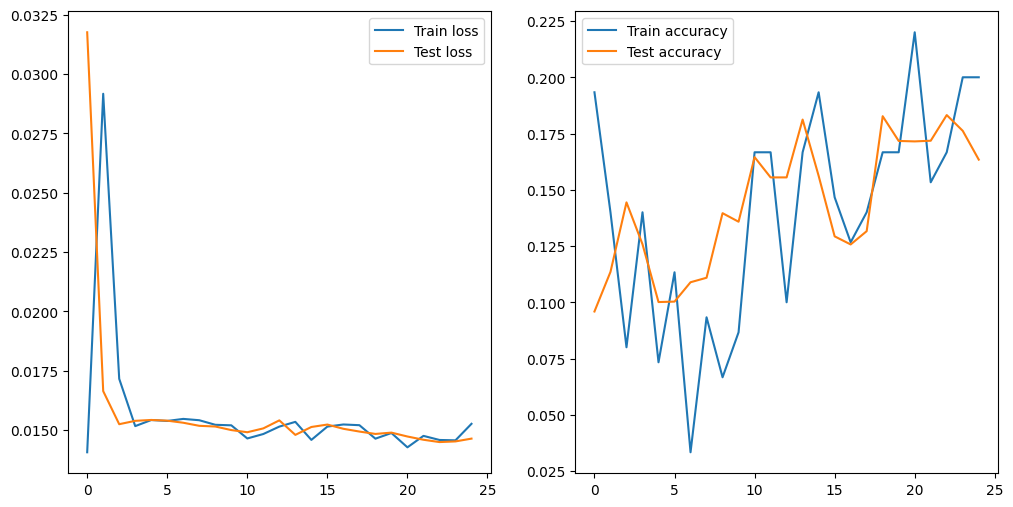

In [38]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(result_4["train_loss"], label="Train loss")
plt.plot(result_4["test_loss"], label="Test loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(result_4["train_acc"], label="Train accuracy")
plt.plot(result_4["test_acc"], label="Test accuracy")
plt.legend()

# Model_5
1. Pre-trained model -> CIFAR10
2. Model_4 VS. Pre-trained model
3. Pre-trained model -> cat, dog dataset